#### 自作モジュールの参照先を上書き

In [1]:
import sys

parent_dir = 'Predict-Future-Sales'
p_sub = sys.path[0]

ride = ''
for path in p_sub.split('/'):
    if path != parent_dir:
        ride = ride + path + '/'
    else:
        ride = ride + path + '/'
        break
sys.path[0] = ride

import time
import pickle

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt

from module.lino_module.preprocess import time_series_dataset
from module.lino_module.model import TransformerModel, training


seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

/Users/lino/opt/anaconda3/envs/for_pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## データセットの準備

In [2]:
seq=14
int(seq*0.9), int(seq*0.4)

(12, 5)

In [3]:
data = pd.read_csv('../data/sales_train.csv')

seq = 7
d_model = 32
dilation = 1
src_tgt_seq = (int(seq * 0.9),int(seq * 0.4))

kwrgs = {'data': data,
         'seq': seq,
         'd_model': d_model,
         'dilation': dilation,
         'src_tgt_seq': src_tgt_seq}

train, test = time_series_dataset(**kwrgs)

## 訓練用モデルの準備

In [4]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

nhead = 8
transformer = TransformerModel(d_model, nhead).to(device)
# criterion = RMSELoss()  # 論文ではRMSELoss
criterion = nn.MSELoss()

# 学習率その他は論文の値を参考
step_num = 1
warmup_steps = 5000
lr = d_model**0.5 * min(step_num**0.5, step_num * warmup_steps**(-1.5))
optimizer = Adam(transformer.parameters(), lr=1e-5, betas=(0.95, 0.98), eps=10e-9)

## モデル訓練

In [5]:
epochs = 100
training_kwrgs = {'model': transformer,
                  'dataset': train,
                  'device': device,
                  'criterion': criterion,
                  'optimizer': optimizer,
                  'epochs': epochs,
                  'verbose': 10,
                  'center': 50}
transformer, train_loss, validation_loss = training(**training_kwrgs)

--------------------- start ----------------------
                     epoch_0                      
train_loss:  1.1767 | validation_loss:  1.1289 | time:  1.594
                     epoch_10                     
train_loss:  0.5901 | validation_loss:  0.491 | time:  1.44
                     epoch_20                     
train_loss:  0.4974 | validation_loss:  0.3958 | time:  1.331
                     epoch_30                     
train_loss:  0.444 | validation_loss:  0.3421 | time:  1.357
                     epoch_40                     
train_loss:  0.3948 | validation_loss:  0.308 | time:  1.323
                     epoch_50                     
train_loss:  0.372 | validation_loss:  0.2814 | time:  1.337
                     epoch_60                     
train_loss:  0.3517 | validation_loss:  0.2626 | time:  1.419
                     epoch_70                     
train_loss:  0.3229 | validation_loss:  0.2495 | time:  1.757
                     epoch_80                     

モデルの保存

In [6]:
name = f'seq{seq}_dmodel{d_model}_dilation{dilation}'

model = {'model': transformer, 'env': kwrgs}
model_dir = './models/'
model_name = name + '.pkl'
with open(model_dir + model_name, 'wb') as f:
    pickle.dump(model, f)

### 訓練データ損失と検証データ損失

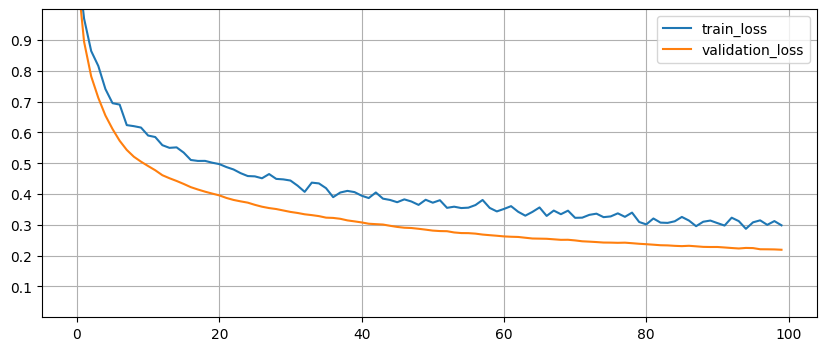

In [7]:
plt.figure(figsize=(10, 4))
plt.plot([torch.mean(i) for i in train_loss], label=('train_loss'))
plt.plot([torch.mean(i) for i in validation_loss], label='validation_loss')
plt.legend()
plt.yticks([round(i*1e-1, 1) for i in range(1, 10)])
plt.grid(axis='x')
plt.grid(axis='y')
plt.ylim(0, 1)
img_path = '../Lino_notebook/img/'
loss_name = f'Loss({name}).png'
plt.savefig(img_path + loss_name)
plt.show()

### 訓練データとテストデータで予測

In [8]:
transformer.eval()
train_preds = []
for src, tgt, _ in train:
    train_pred = transformer(src, tgt)
    train_preds.append(train_pred[:, -1])

test_preds = []
for src, tgt, _ in test:
    test_pred = transformer(src, tgt)
    test_preds.append(test_pred[:, -1])

In [9]:
import datetime
from module.lino_module.preprocess import _mode_of_freq

# 比較用に訓練に使用した時系列データを用意
original = _mode_of_freq(data).item_cnt_day
# 訓練データ, テストデータとのラグを計算
lag = d_model * (dilation + 1) + seq

fit_target = original.values.reshape(-1,1)
src = StandardScaler().fit(fit_target)

# 予測データを ndarray に変換してプロットできるようにする
train_pred = torch.concat(train_preds).reshape(-1).detach().numpy()
test_pred = torch.concat(test_preds).reshape(-1).detach().numpy()

# 予測データの標準化を解除
train_pred = src.inverse_transform(train_pred.reshape(-1, 1)).reshape(-1)
test_pred = src.inverse_transform(test_pred.reshape(-1, 1)).reshape(-1)

# 訓練データラベルのラグを修正
tr_start = original.index[0] + datetime.timedelta(lag)
tr_end = tr_start + datetime.timedelta(len(train_pred) - 1)
tr_idx = pd.date_range(tr_start, tr_end)
# ラグを修正したインデックスでプロット用の訓練予測データを作成
train_time_series = pd.Series(train_pred, index=tr_idx)

# テストデータのラグを修正
te_start = tr_end + datetime.timedelta(1)
te_end = te_start + datetime.timedelta(len(test_pred) - 1)
te_idx = pd.date_range(te_start, te_end)
# ラグを修正したインデックスでプロロット用のテスト予測データを作成
test_time_series = pd.Series(test_pred, index=te_idx)

### 予測データのプロット

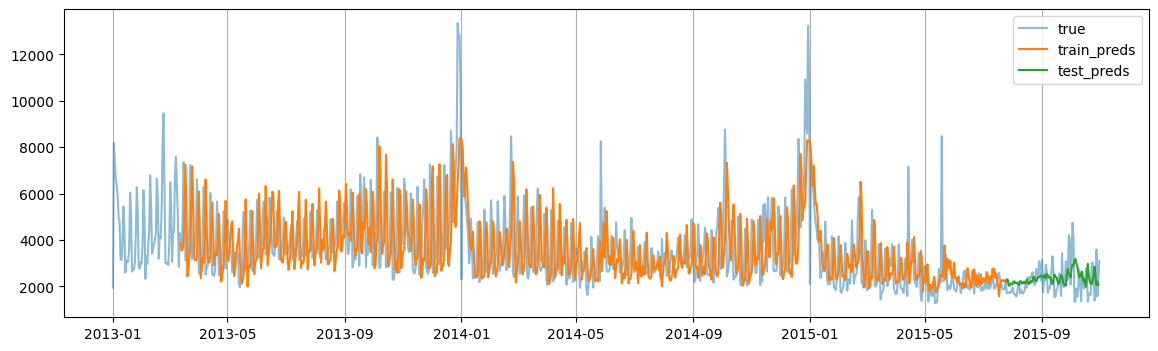

In [12]:
plt.figure(figsize=(14, 4))
plt.plot(original, alpha=0.5, label='true')
plt.plot(train_time_series, label='train_preds')
plt.plot(test_time_series, label='test_preds')
plt.grid(axis='x')
plt.legend()

predict_name = f'Predict({name}).png'
plt.savefig(img_path + predict_name)
plt.show()